# Readme
Run this notebook with environment HEEPS. Written by Gilles Otten

# Importing modules

In [1]:
import numpy as np
from astropy.io import fits
import scipy.interpolate
import matplotlib.pyplot as plt
import scipy.signal
import astropy.modeling
from vip_hci.preproc import frame_rotate
from heeps.util.paralang import paralang
import heeps

# Loading METIS on and off-axis PSFs

In [12]:
psf_on=fits.getdata("~/heeps_metis/output_files/onaxis_PSF_N2_CVC.fits")
psf_off=fits.getdata("~/heeps_metis/output_files/offaxis_PSF_N2_CVC.fits")
conf = heeps.config.read_config(verbose=False,band="N2",nframes=100,mode="CVC",call_ScopeSim=False,dit=0.011)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
pscale=conf['pscale']
ndet=conf['ndet']
nframes=conf['nframes']
duration=conf['duration']
lat=conf['lat'] # observatory latitude
dec=conf['dec'] # target declination

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.1072
   npupil=119, pscale=6.7900 mas, lam=1.1330E-05 m
   hfov=1.1 arcsec (-> ndet=325, 17.42 lam/D)



# Load transmission factors
The transmission losses in the coronagraph are not taken into account automatically in ScopeSim, therefore we keep track of these factors and apply it to ScopeSim in a later section.

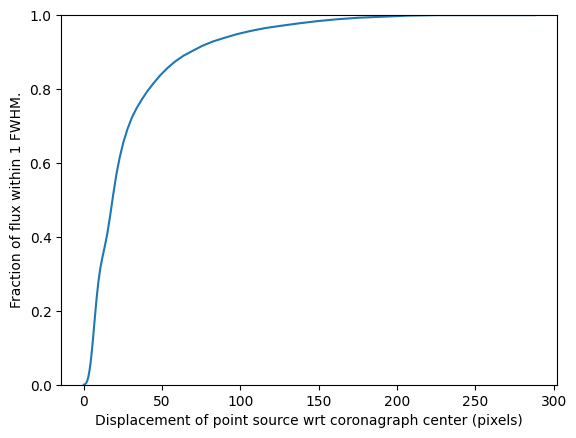

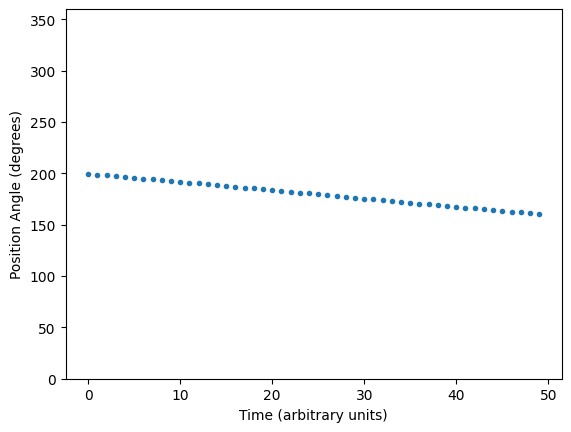

In [13]:
# also load off-axis transmission curve
oat_n2=fits.getdata("~/heeps_metis/input_files/optics/vc/oat_N2_CVC.fits")
oat_rad,oat_trans=oat_n2

plt.plot(oat_rad,oat_trans)
plt.xlabel("Displacement of point source wrt coronagraph center (pixels)")
plt.ylabel("Fraction of flux within 1 FWHM.")
plt.ylim([0,1])
plt.show()

f_oat=scipy.interpolate.interp1d(oat_rad,oat_trans) # make radial interpolation function for off-axis transmission

# calculate field rotation in 1 hour of observing time.
pa = paralang(nframes//2, dec, lat, duration) # number of frames (we only allocate half to the science), declination of target, latitude of observatory, total sequence time in seconds.
pa = (pa + 360)%360

plt.plot(pa,".")
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Position Angle (degrees)")
plt.ylim([0,360])
plt.show()




# Generate source, apply sky rotation and convolve with PSF
In high-contrast imaging the pupil of the telescope is typically tracked through the derotator to keep PSF patterns stable on the detector. It also allows to mask the telescope's spiders with an internal pupil mask. This tracking process means the (sky)field rotates as seen by the detector. To mimic this effect we calculate the on-sky position angle in time and use it to rotate our source. The rotated source images are then convolved with the PSF and the radial off-axis transmission is applied. An on-axis PSF is added as a central point source (star)

In [14]:
xx,yy=np.meshgrid(np.arange(ndet)-((ndet-1)/2),np.arange(ndet)-((ndet-1)/2))
rr=np.sqrt(xx**2+yy**2)
f_gauss=astropy.modeling.functional_models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, x_stddev=10, y_stddev=40, theta=15/180*np.pi)
source0=f_gauss(xx,yy) # fake Gaussian disk source
#print(source0.sum(),(f_gauss.x_stddev*f_gauss.y_stddev*f_gauss.amplitude*2*np.pi))
source0=source0/(f_gauss.x_stddev*f_gauss.y_stddev*f_gauss.amplitude*2*np.pi) # normalize by the analytical sum of the gaussian

# apply field rotation to the source before convolution with PSF
cube=np.zeros([nframes//2,ndet,ndet]) # only use half of the generated PSFs for the science.
cube_new=np.zeros([nframes//2,ndet,ndet])
#cube_new_ref=np.zeros([50,325,325])
for i,p in enumerate(pa):
    cube[i,:,:]=frame_rotate(source0,p)

# convolve disk with off-axis PSF if it is extended and multiply off-axis object by the oat to mimic coronagraphic suppression
# to get a more accurate representation it would be needed to loop over coronagraphic focal plane mask offsets and weigh each PSF with the intensity. This is too calculation-heavy for this notebook.
# in addition we add an on-axis PSF as a stellar source.
cube_new=scipy.signal.fftconvolve(cube[:,:,:],psf_off[0:nframes//2,:,:],axes=[1,2],mode='same')*f_oat(rr)
cube_new=cube_new*10**(-0.4*3)+psf_on[0:nframes//2,:,:]*10**(-0.4*0) # scale disk in total intensity to N2=3 and add N2=0 on-axis stellar source
fits.writeto("source_cube.fits",cube_new,overwrite=True)
fits.writeto("source_cube_ref.fits",psf_on[nframes//2::,:,:],overwrite=True)
fits.writeto("source_cube_off.fits",psf_off[nframes//2::,:,:],overwrite=True)